# Homework 11
# By Yukun Wan (yw3447)

# Time series clustering exercise

## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [46]:
import pandas as pd
import zipfile 
import os
import urllib.request as urllib
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as pl
import scipy.cluster as scp
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
%matplotlib inline

# 1. Data Cleaning

## Download the census bureau business data for all years 1993-2014. 
You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
!for ((y=93; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; mv zbp$y\totals.zip $PUIDATA; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; mv zbp0$y\totals.zip $PUIDATA; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV//zbp0$y\totals.zip; mv zbp0$y\totals.zip $PUIDATA; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV//zbp$y\totals.zip; mv zbp$y\totals.zip $PUIDATA; done



--2017-12-13 22:44:00--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp93totals.zip
Resolving www2.census.gov... 23.203.69.65, 2600:1408:1d:386::208c, 2600:1408:1d:38b::208c
Connecting to www2.census.gov|23.203.69.65|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-12-13 22:44:01 ERROR 404: Not Found.

mv: rename zbp93totals.zip to /Users/wanyukun/PUIdata/zbp93totals.zip: No such file or directory
--2017-12-13 22:44:01--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 23.203.69.65, 2600:1408:1d:386::208c, 2600:1408:1d:38b::208c
Connecting to www2.census.gov|23.203.69.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: 'zbp94totals.zip'

zbp94totals.zip     100%[===================>] 597.19K  --.-KB/s    in 0.09s   

2017-12-13 22:44:01 (6.68 MB/s) - 'zbp94totals.zip' saved [611524/611524]

--2017-12-13 22:44:01--  https://www2.c

Connecting to www2.census.gov|23.203.69.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: 'zbp09totals.zip'

zbp09totals.zip     100%[===================>] 644.64K  --.-KB/s    in 0.09s   

2017-12-13 22:44:04 (6.98 MB/s) - 'zbp09totals.zip' saved [660109/660109]

--2017-12-13 22:44:04--  https://www2.census.gov/econ2010/CBP_CSV//zbp10totals.zip
Resolving www2.census.gov... 23.203.69.65, 2600:1408:1d:386::208c, 2600:1408:1d:38b::208c
Connecting to www2.census.gov|23.203.69.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: 'zbp10totals.zip'

zbp10totals.zip     100%[===================>] 778.84K  --.-KB/s    in 0.1s    

2017-12-13 22:44:04 (6.94 MB/s) - 'zbp10totals.zip' saved [797534/797534]

--2017-12-13 22:44:04--  https://www2.census.gov/econ2011/CBP_CSV//zbp11totals.zip
Resolving www2.census.gov... 23.203.69.65, 2600:1408:1d:386::208c, 2600:14

 ## Download the NYC zipcodes shapefile. 
 
 
 One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [3]:
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application/zip"
urllib.urlretrieve(url,'nyczip.zip')
os.system('mv nyczip.zip $PUIDATA')
os.system('unzip -o $PUIDATA/nyczip.zip -d $PUIDATA/nyczip')

0

## Read NYC zipcode shapefile

In [4]:
NYCzip = gpd.read_file(os.getenv('PUIDATA') + '/nyczip/ZIP_CODE_040114.shp')

In [5]:
NYCzip.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [6]:
ziplist = NYCzip.ZIPCODE.unique().astype(int)

In [7]:
len(ziplist)

248

## Read census bureau business data

In [49]:
zipest = pd.DataFrame(ziplist)
zipest.columns = ['ZIP']

In [50]:
YEARS = map(str,range(1994, 2015, 1))
YEARS = map(lambda x:x[2:4],YEARS)

In [51]:
for y in YEARS:
    fname = os.getenv("PUIDATA") + '/zbp' + y + 'totals.zip'
    df = pd.read_csv(fname)
    df.columns = map(str.upper, df.columns)
    temp = df[np.in1d(df.ZIP, ziplist)].loc[:,['ZIP','EST']]
    temp.columns = ['ZIP','EST' + y ]
    zipest = zipest.merge(temp,on='ZIP',how='left')

In [52]:
zipest.set_index('ZIP',inplace=True)
zipest.head()

,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,EST03,...,EST05,EST06,EST07,EST08,EST09,EST10,EST11,EST12,EST13,EST14
ZIP,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [53]:
zipest.shape

(248, 21)

In [54]:
# Remove zipcode with all NaN
zipest.dropna(how='all',axis=0,inplace=True)

In [55]:
zipest_mean = zipest.iloc[:,:].mean(axis=1)
zipest_std = zipest.iloc[:,:].std(axis=1)
zipest.iloc[:,:] = zipest.iloc[:,:].apply(lambda x: (x- zipest_mean) / zipest_std)

In [56]:
zipest.fillna(0,inplace=True)

# 2. Cluster the NUMBER OF ESTABLISHMENTS time series with K-means

In [57]:
for n in range(2,10):
    KM = KMeans(n_clusters=n, random_state=2017)
    res = KM.fit(zipest)
    silhouette_avg = silhouette_score(zipest, res.labels_)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.5365708006976528
For n_clusters = 3, the average silhouette_score is : 0.4820598662860804
For n_clusters = 4, the average silhouette_score is : 0.46604856567502695
For n_clusters = 5, the average silhouette_score is : 0.32278948150307607
For n_clusters = 6, the average silhouette_score is : 0.3107601518324908
For n_clusters = 7, the average silhouette_score is : 0.32656515862761026
For n_clusters = 8, the average silhouette_score is : 0.16122951513563918
For n_clusters = 9, the average silhouette_score is : 0.2938079062746441


**The silhouette_score keeps droping as clustering number increases. If based on the value, I would choose n = 2. However, in order to finding some possible patterns, I decided to plot clusters in n = 3,5,7 and decide.**

In [58]:
n = [3,5,7]
for i in n:
    KM = KMeans(n_clusters=i,random_state=2017)
    res = KM.fit(zipest)
    zipest['labelKM' + str(i)] = res.labels_

In [59]:
zipest.head()

,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,EST03,...,EST08,EST09,EST10,EST11,EST12,EST13,EST14,labelKM3,labelKM5,labelKM7
ZIP,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,2,0,1
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,2,0,1
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,2,0,1
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,2,0,1
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,2,0,1


In [60]:
zipest.shape

(245, 24)

# 3. Plot K-means cluster center

### define function to plot cluster center

In [61]:
x = range(21)
def plotcenter(fig,num,t):
    '''
    num: number of clusters
    t: KM or H
    '''
    for i in range(num):
        ax = fig.add_subplot(num/2 + 1,2,i+1)
        sub = zipest[zipest['label' + str(t) + str(num)]==i].iloc[:,range(21)]
        mean = sub.mean(axis=0)
        #print(mean)
        for j in range(len(sub)):
            ax.plot(x,sub.iloc[j,range(21)],'steelblue',alpha=0.6)
        ax.plot(x,mean,'indianred',linewidth=8)
        ax.set_title('Cluster {}'.format(i))
        ax.set_xlabel('Year')
        #pl.xticks(arange(21),ziplist,rotation=60)
    #pl.suptitle('K-means cluster',size=16)
    #plt.subplots_adjust(left=0.2, top=0.2)
    #pl.tight_layout()
    pl.show()

#### Number of K-means clusters = 3

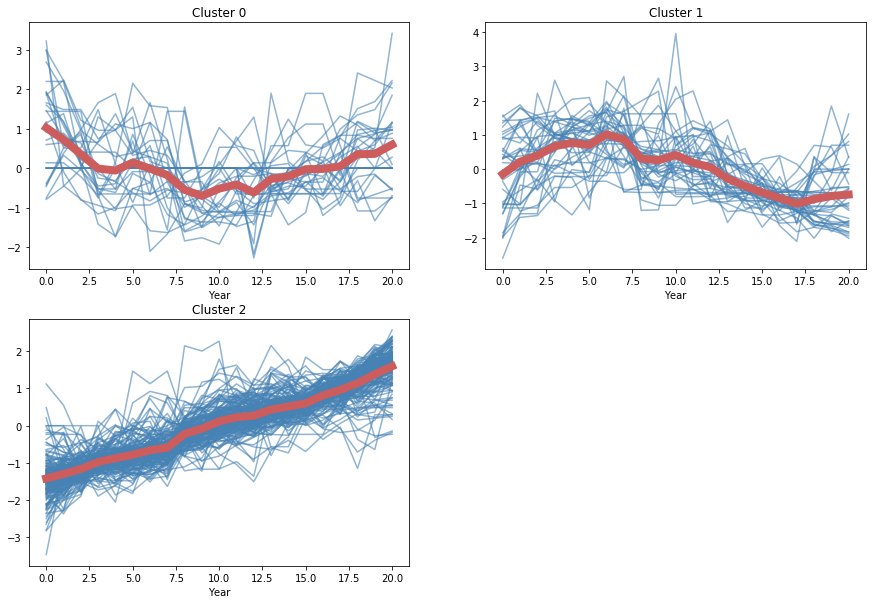

In [62]:
fig = pl.figure(figsize=(15,10))
plotcenter(fig,3,'KM')

### Figure 1: Plots of business pattern time seires by KMeans cluster with the cluster centers. Number of clusters is 3.

#### Number of K-means clusters = 5

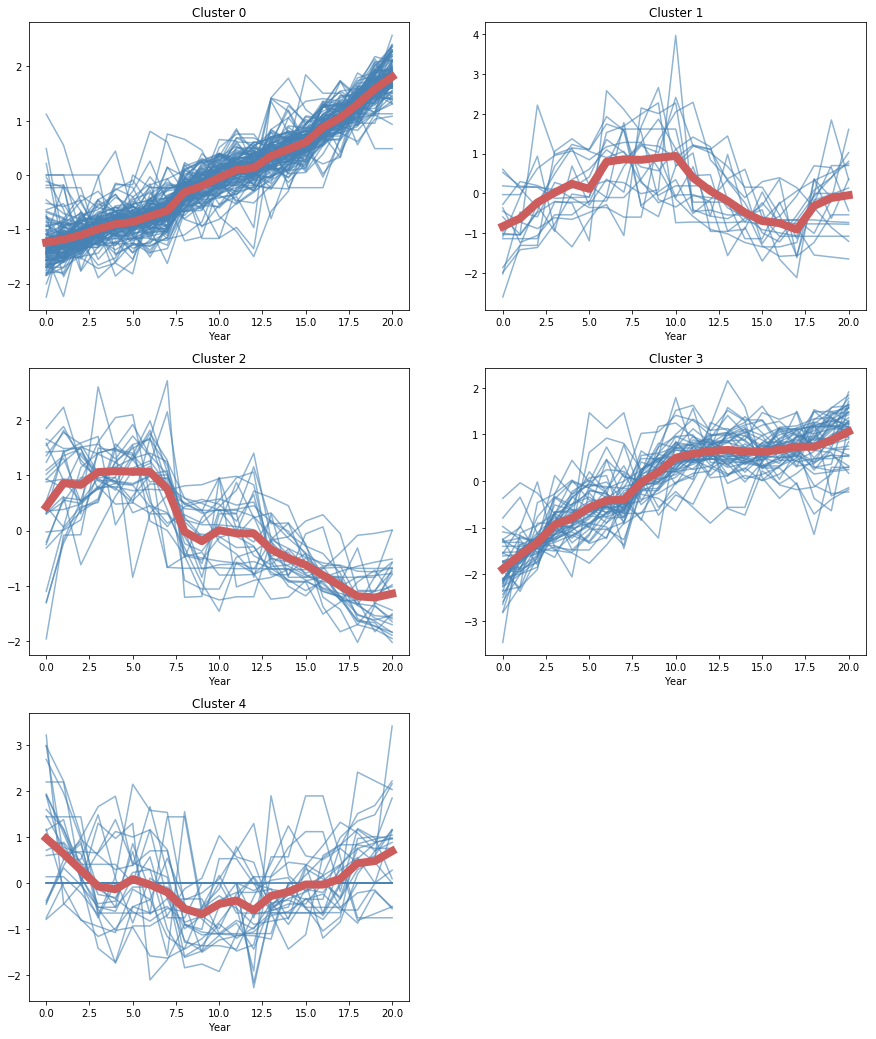

In [63]:
fig = pl.figure(figsize=(15,18))
plotcenter(fig,5,'KM')

### Figure 2: Plots of business pattern time seires by KMeans cluster with the cluster centers. Number of clusters is 5.

#### Number of K-means clusters = 7

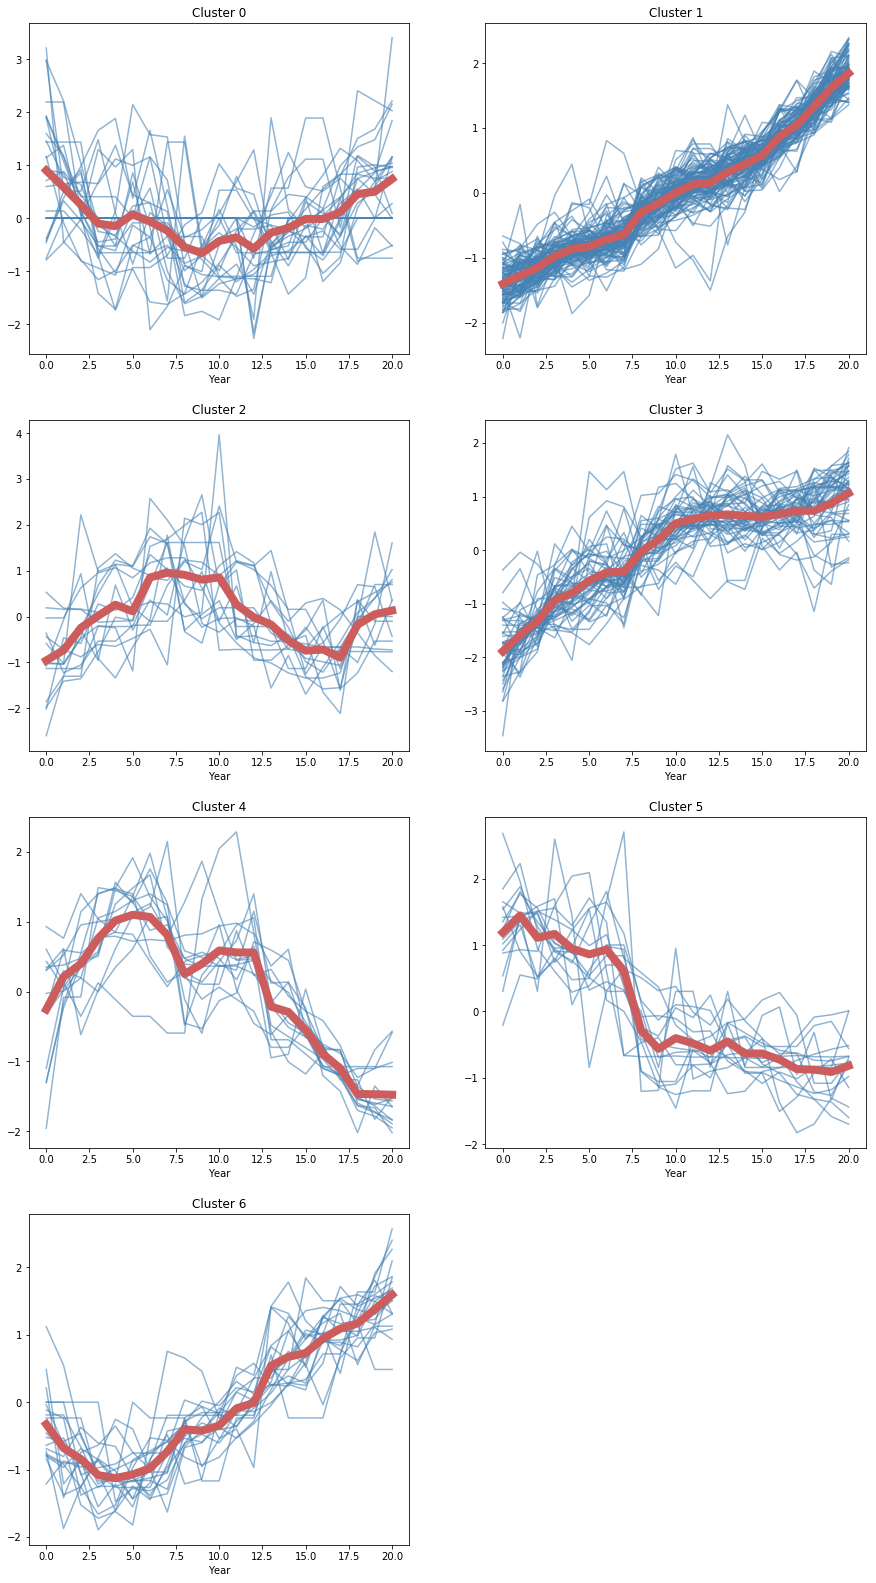

In [64]:
fig = pl.figure(figsize=(15,28))
plotcenter(fig,7,'KM')

### Figure 3: Plots of business pattern time seires by KMeans cluster with the cluster centers. Number of clusters is 7.

### After reviewing the Figure 1-3, I'd like to choose the second clustering (number of clusters = 5) as the appropriate K-means clustering.

# 4. Use hierarchical clustering

In [65]:
zipest.head()

,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,EST03,...,EST08,EST09,EST10,EST11,EST12,EST13,EST14,labelKM3,labelKM5,labelKM7
ZIP,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,2,0,1
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,2,0,1
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,2,0,1
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,2,0,1
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,2,0,1


### Distance dendrogram

In [66]:
wc = zipest.iloc[:,range(21)].as_matrix(columns = zipest.iloc[:,range(21)].columns)

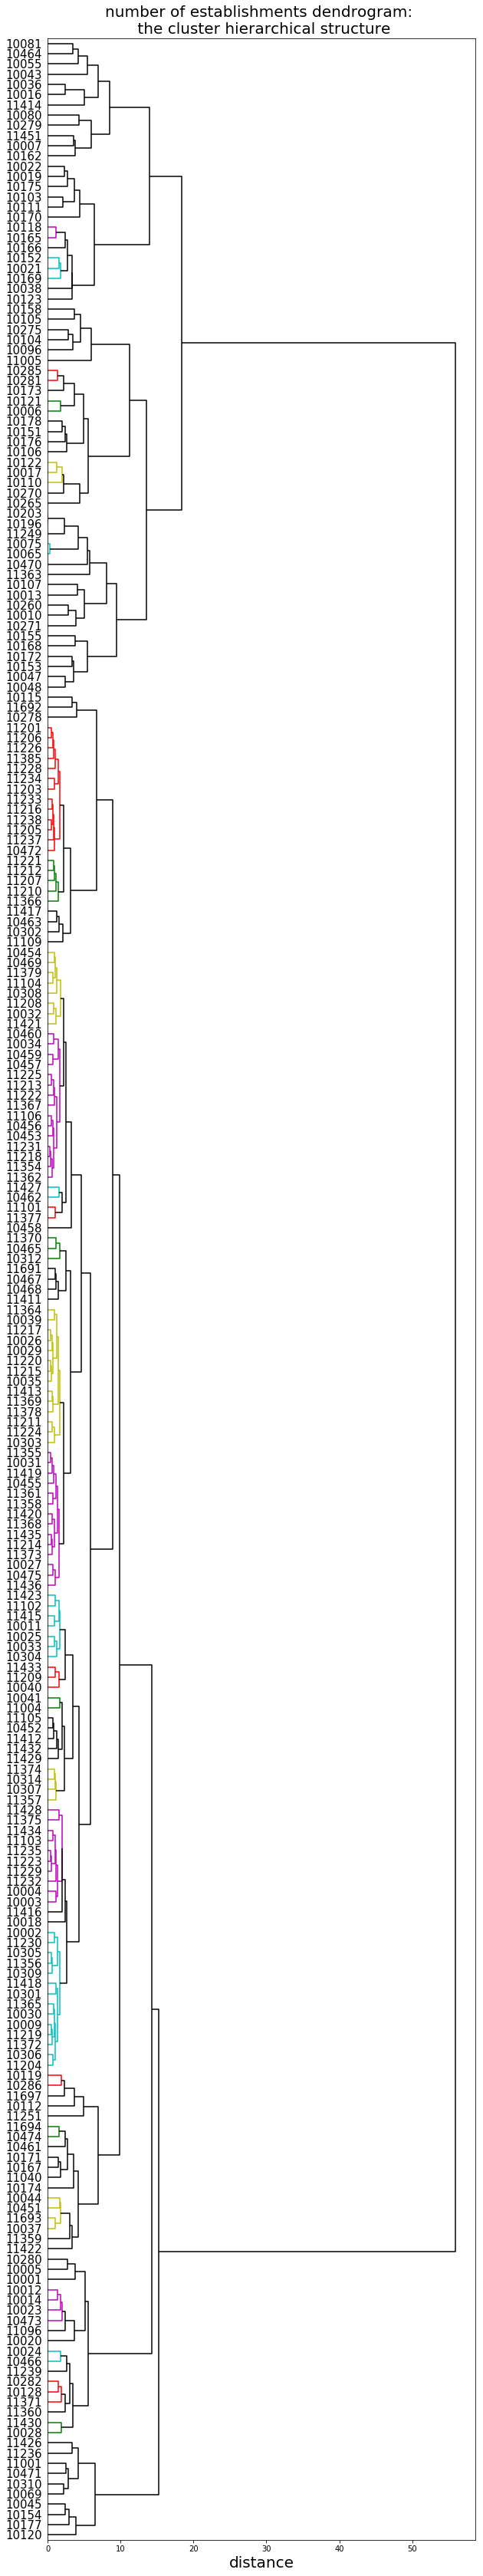

In [67]:
fig = pl.figure(figsize=(10,60))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(wc, method='ward'),
                               labels = zipest.index.values,
                               leaf_rotation=90.,# rotates the x axis labels
                               leaf_font_size=20, p=12, #truncate_mode='lastp', 
                               show_contracted=True, color_threshold = 2, 
                               orientation='right', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.yticks(fontsize=15, rotation=0)
pl.grid('off')
pl.title("number of establishments dendrogram: \n the cluster hierarchical structure", fontsize=20)
#this is a dendrogram for inspection of the hierarchical structure

### Figure 4: Dandrogram of number of establishments clusters, eucledian distance in lat-lon space, Ward linkage

### Run Agglomerative clustering for 3/5/7 clusters

In [68]:
n = [3,5,7]
for i in n:
    agc = AgglomerativeClustering(n_clusters = i, compute_full_tree = True).fit(zipest)
    zipest['labelH' + str(i)] = agc.labels_

In [69]:
zipest.head()

,EST94,EST95,EST96,EST97,EST98,EST99,EST00,EST01,EST02,EST03,...,EST11,EST12,EST13,EST14,labelKM3,labelKM5,labelKM7,labelH3,labelH5,labelH7
ZIP,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,1.266793,0.959248,1.164278,1.676853,2,0,1,2,2,5
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,1.022634,1.499252,1.765058,1.920875,2,0,1,2,2,5
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,1.422605,1.518781,1.639001,1.891464,2,0,1,2,2,5
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,1.065830,1.341371,1.871258,2.115007,2,0,1,2,2,5
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.998909,1.375964,1.753018,1.978331,2,0,1,2,2,5


# Plot Agglomerative cluster center

#### Number of hierarchical clusters = 3

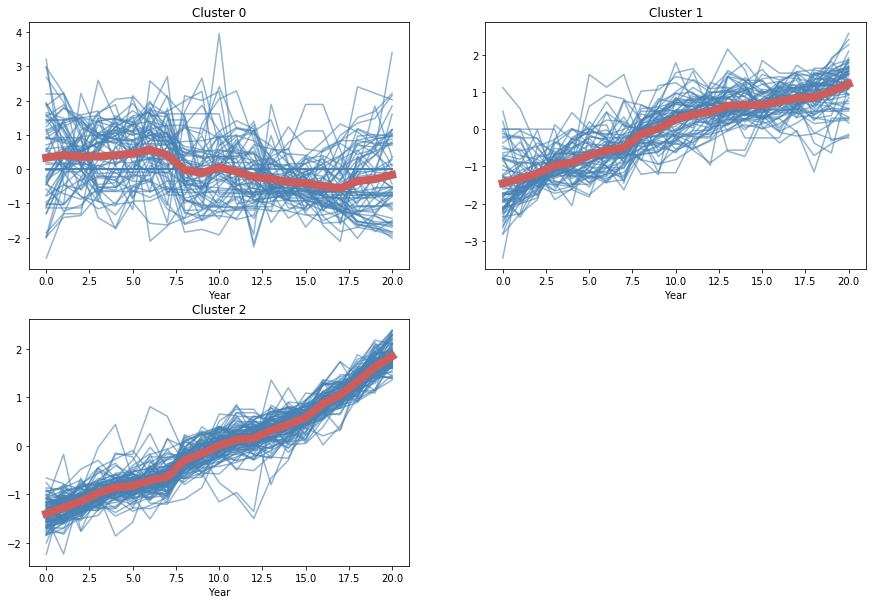

In [70]:
fig = pl.figure(figsize=(15,10))
plotcenter(fig,3,'H')

### Figure 5: Plots of business pattern time seires by Agglomerative cluster with the cluster centers. Number of clusters is 3.

#### Number of hierarchical clusters = 5

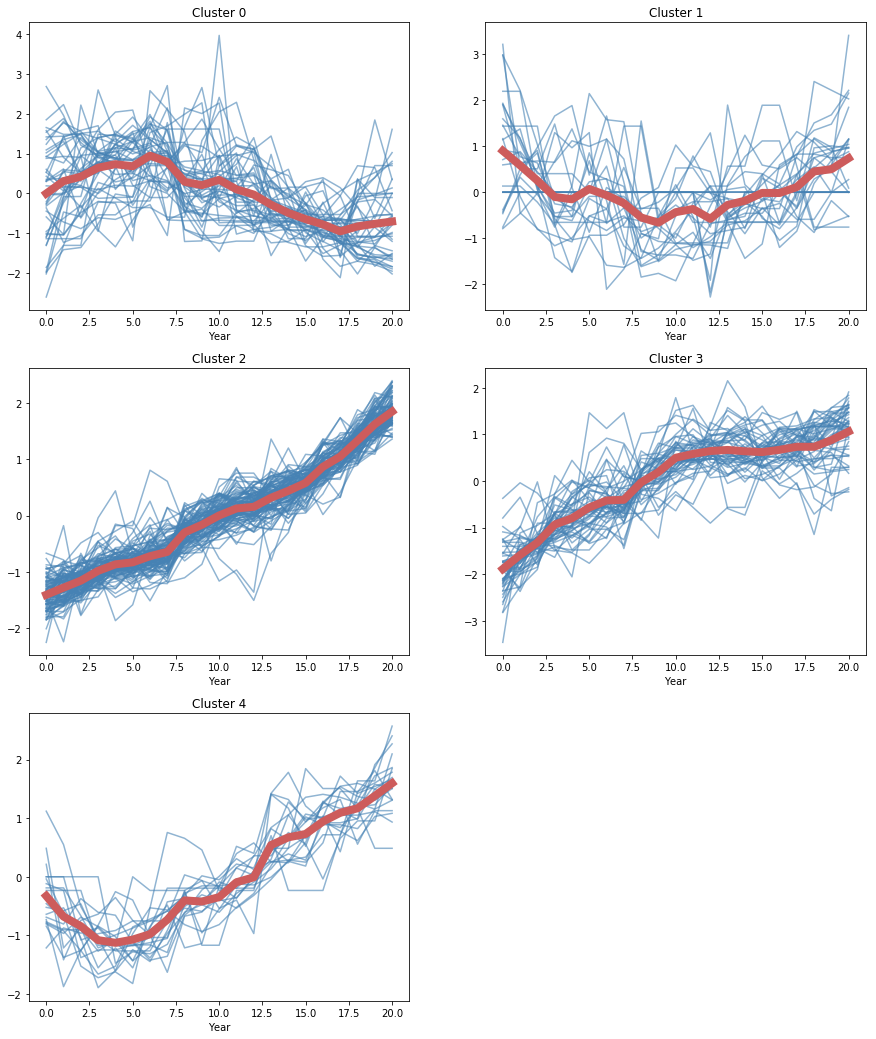

In [71]:
fig = pl.figure(figsize=(15,18))
plotcenter(fig,5,'H')

### Figure 6: Plots of business pattern time seires by Agglomerative cluster with the cluster centers. Number of clusters is 5.

#### Number of hierarchical clusters = 7

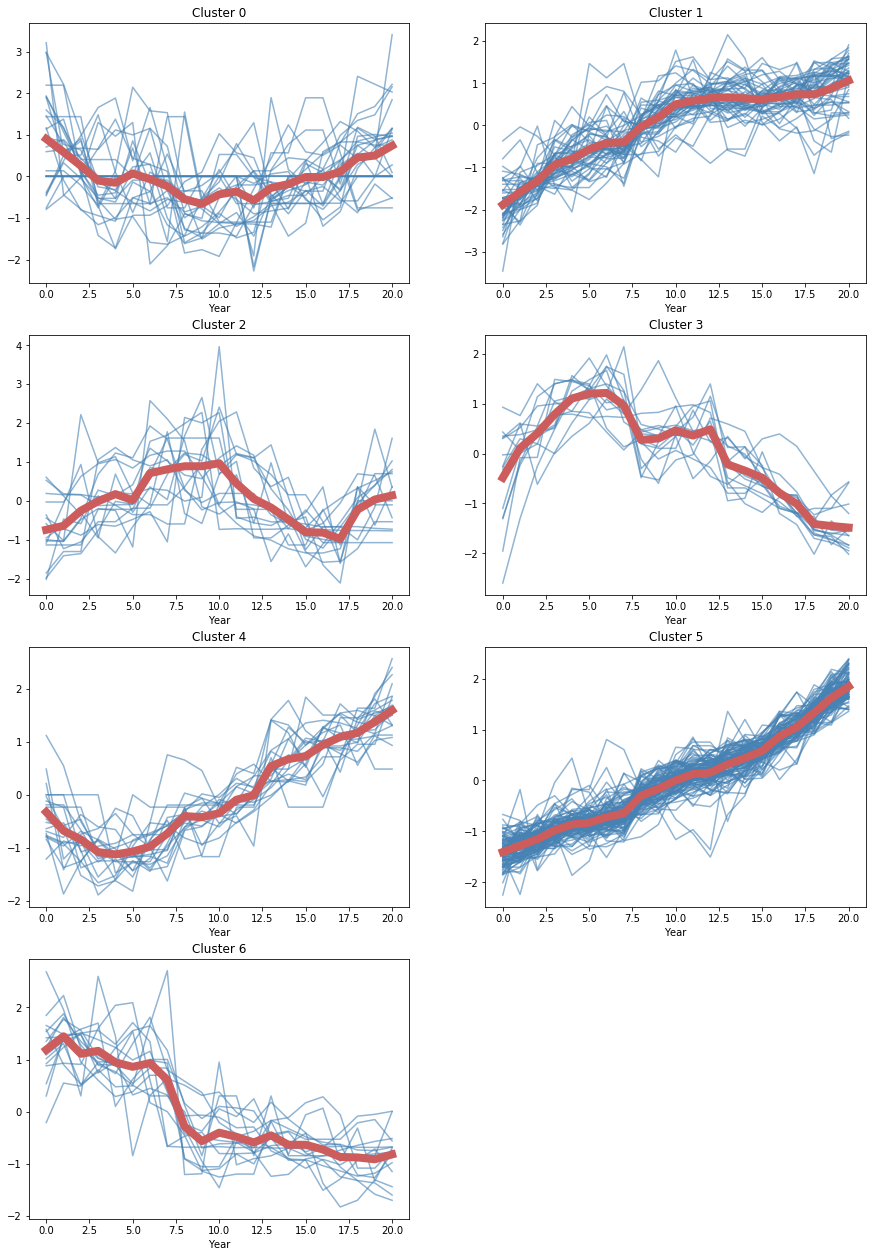

In [72]:
fig = pl.figure(figsize=(15,22))
plotcenter(fig,7,'H')

### Figure 7: Plots of business pattern time seires by Agglomerative cluster with the cluster centers. Number of clusters is 7.

### After reviewing the Figure 5-7, I'd like to choose the second clustering (number of clusters = 5) as the appropriate agglomerative clustering.

# 5. Overlay data on a NYC map

In [73]:
NYCzip.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [74]:
len(NYCzip),len(zipest)

(263, 245)

In [75]:
NYCzip.ZIPCODE = NYCzip.ZIPCODE.astype(int)

In [76]:
NYCzipKM = NYCzip.merge(zipest[['labelKM5']],left_on='ZIPCODE',right_index=True)

In [77]:
NYCzipH = NYCzip.merge(zipest[['labelH5']],left_on='ZIPCODE',right_index=True)

## 5.1 NYC map in K means clustering

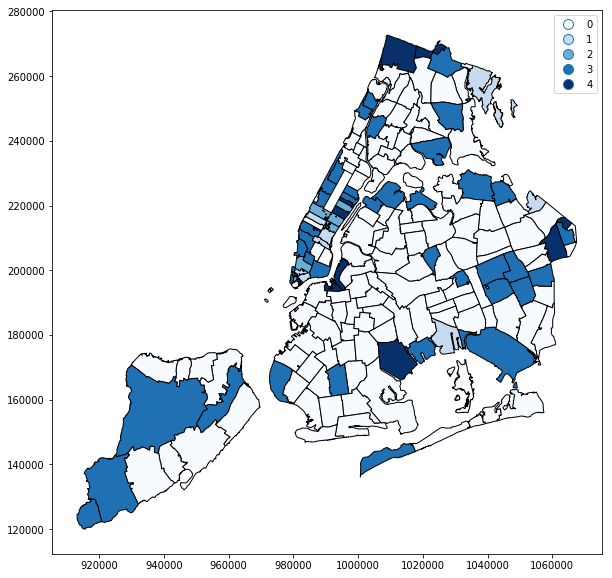

In [78]:
NYCzipKM.plot(figsize=(10,10),column='labelKM5',cmap='Blues',edgecolor='black',legend=True,categorical=True)

### Figure 8: Plot the business patterns (number of businesses) in k-means clusters (n=5) at the zipcode level for NYC zipcodes: each color indicates a cluster.

## 5.2 NYC map in  agglomerative clustering

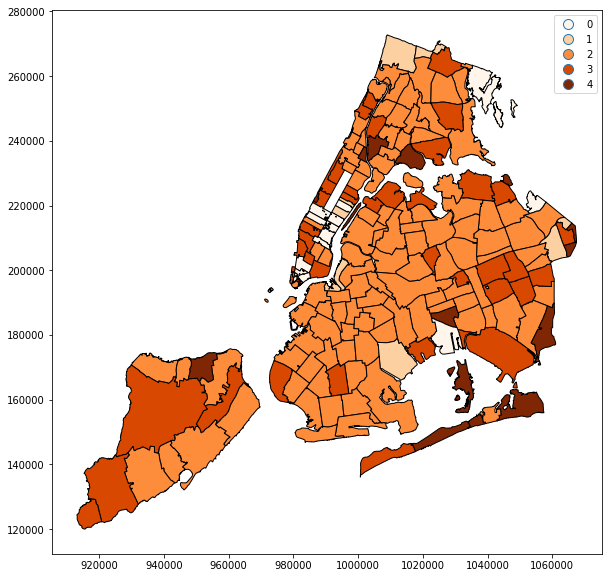

In [79]:
NYCzipH.plot(figsize=(10,10),column='labelH5',cmap='Oranges',edgecolor='black',legend=True,categorical=True)

### Figure 9: Plot the business patterns (number of businesses) in agglomerative clusters (n=5) at the zipcode level for NYC zipcodes: each color indicates a cluster.

# 6. Compare the results of the 2 algorithms


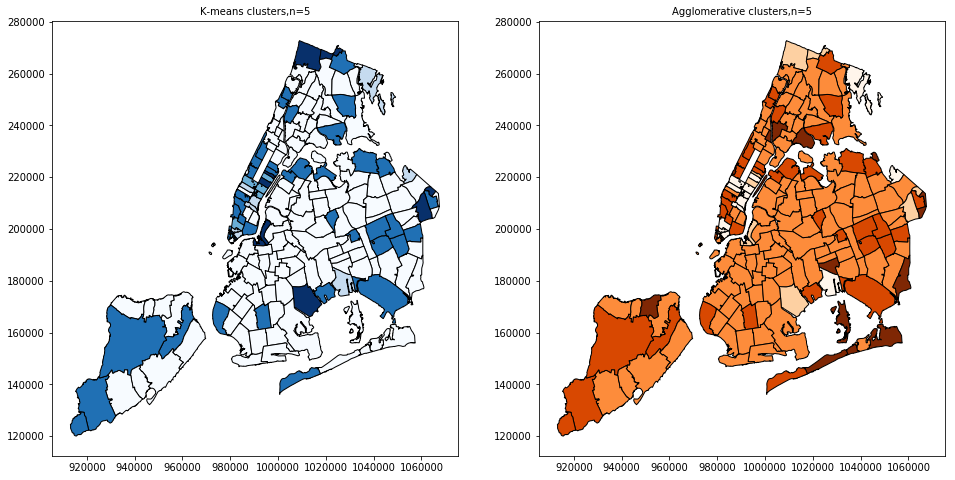

In [80]:
f, (ax1, ax2) = pl.subplots(1,2,figsize=(16,8))
ax1.set_title('K-means clusters,n=5',fontsize=10)
NYCzipKM.plot(column='labelKM5',cmap='Blues',ax=ax1,edgecolor='black')
ax2.set_title('Agglomerative clusters,n=5',fontsize=10)
NYCzipH.plot(column='labelH5',cmap='Oranges',ax=ax2,edgecolor='black')

### Figure 10: KMeans vs. Hierarchical Clustering Dendrogram of number of establishments, both within clustering of 5.


# 7. Interpretation:

As we can see in the Figure 10, most areas in NYC share the same pattern. There are difference between two types of algorithms in the north of Bronx, the east of Queens, the south-east of Brooklyn, and the north of Staten Island, the upper and lower Manhattan.

Points: 10